## 作业2：ADAMS和RK4数值积分的实现
仿照run_euler函数的实现，在modsim中实现Adams和四阶Runge-Kutta法，并使用炮弹发射仿真比较Euler、Adams和RK4三种数值积分的精度。实现run_adams和run_rk4函数。

In [599]:
%matplotlib inline

%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

from modsim import *

使用init对象存储每步的$x$和$y$值

In [600]:
init = State(x=0,y=1)

,values
x,0
y,1


使用System对象存储初始步数$t_0$，终止步数$t_{end}$和步长$h$

In [601]:
system = System(init=init, t_0=0, t_end=30, h=1)

,values
init,x 0 y 1 dtype: int64
t_0,0
t_end,30
h,1


对于一个常微分方程：
$$\frac{dy}{dx}=f(x,y)$$
$$y(x_0)=y_0$$
四阶龙格库塔法的算法如下：
$$y(i+1)=y(i)+\frac{h}{6}\times(K_1+2K_2+2K_3+K_4)$$
其中：
$$k_1=f(x(i) , y(i))$$
$$k_2=f(x(i)+\frac{h}{2},y(i)+\frac{h}{2}k_1)$$
$$k_3=f(x(i)+\frac{h}{2},y(i)+\frac{h}{2}k_2)$$
$$k_4=f(x(i)+h,y(i)+hk_3)$$

下面的Rungle_Kutta函数定义每步的龙格库塔算法

In [602]:
def Rungle_Kutta(fun, state, t, system):

    h = system.h
    x, y = state.x, state.y

    k1 = fun(x,y)
    k2 = fun(x+(h/2), y+k1*(h/2))
    k3 = fun(x+(h/2), y+k2*(h/2))
    k4 = fun(x+h,y+k3*h)

    x += h
    y += h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return State(x=x,y=y)

定义系统仿真函数：

In [603]:
def run_simulation(fun, Rungle_Kutta, system):

    init = system.init
    t_0, t_end, h = system.t_0, system.t_end, system.h
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, h)

    for t in ts:
        frame.row[t+h] = Rungle_Kutta(fun, frame.row[t], t, system)
    
    return frame

定义：
$$f(x,y)=\frac{x^2}{y}$$

In [604]:
def func(x,y):
    f = x ** 2 / y
    return f

运行仿真：

In [605]:
result = run_simulation(func, Rungle_Kutta, system)

,x,y
0,0,1
1,1.0,1.293771
2,2.0,2.524213
3,3.0,4.364128
4,4.0,6.611736
5,5.0,9.186032
6,6.0,12.043703
7,7.0,15.156453
8,8.0,18.503654
9,9.0,22.06926


经过四阶龙格库塔法求解的函数$f(x,y)$的大致图像如下：

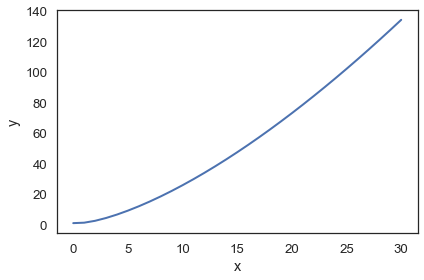

In [606]:
plot(result.y)
decorate(xlabel='x', ylabel='y')

### 程序封装

定义一个初始化函数

In [607]:
def make_system(x_init, y_init, h, t_0, t_end):

    init = State(x=x_init,y=y_init)

    return System(init=init, t_0=t_0, t_end=t_end, h=h)

整个程序可以这样运行：

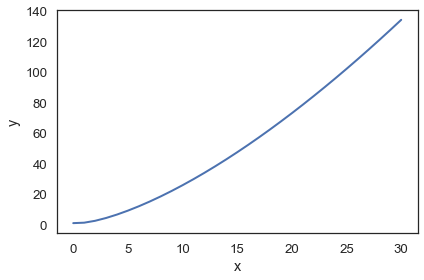

In [608]:
system = make_system(0,1,1,0,30)
results = run_simulation(func, Rungle_Kutta, system)

plot(results.y)
decorate(xlabel='x', ylabel='y')

最终封装为run_rk4函数

In [609]:
def run_rk4(system, func):

    jieguo = run_simulation(func, Rungle_Kutta, system)

    return jieguo

对于炮弹发射问题，在竖直方向上定义速度函数

In [610]:
def sudu (t,v):
    f1 = 9.8
    return f1

用四阶龙格库塔法计算炮弹发射问题：

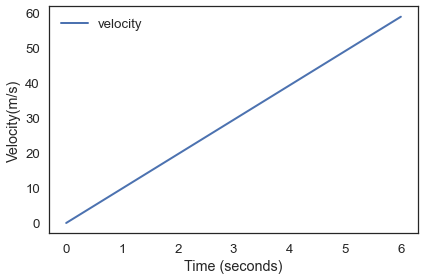

In [611]:
system = make_system(0,0,1,0,6)

results = run_rk4(system, sudu)

plot(results.y, label='velocity')
decorate(xlabel='Time (seconds)',ylabel='Velocity(m/s)')

## 程序改进
显然，上述的run_rk4()函数只能解决一阶常微分方程，若想解决二阶甚至高阶的微分方程，需要对State类的内容进行扩展

下面以二阶常微分方程为例，实现对run_rk4()函数的改进,以实现二阶非齐次微分方程的四阶龙格库塔数值求解

对于一个一般的二阶常微分方程：

$$\frac{d^2y}{dx^2}+P(x,y)\frac{dy}{dx}=Q(x,y)$$
$$y(x_0)=y_0,y'(x_0)=y'_0$$ 

可令

$$z=\frac{dy}{dx}$$

则上述二阶微分方程即可拆成一阶微分方程组：

\begin{equation}
\begin{cases}
\frac{dz}{dx}=-P(x,y)z+Q(x,y)\\
\frac{dy}{dx}=z
\end{cases}
\end{equation}

针对此微分方程组，下面对run_rk4函数进行改进

首先，将State类进行扩展

In [612]:
init = State(x=0,z=0,y=0)

,values
x,0
z,0
y,0


In [613]:
system = System(init=init, t_0=0, t_end=30, h=1)

,values
init,x 0 z 0 y 0 dtype: int64
t_0,0
t_end,30
h,1


重新定义四阶龙格库塔算法

四阶龙格库塔法的算法如下：
$$z(i+1)=z(i)+\frac{h}{6}\times(k_1+2k_2+2k_3+k_4)$$
$$y(i+1)=y(i)+\frac{h}{6}\times(K_1+2K_2+2K_3+K_4)$$
其中：
$$k_1=-z(i)P(x(i),y(i))+Q(x(i),y(i))$$
$$K_1=z(i)+\frac{h}{6}k_1$$
$$k_2=-(z(i)+\frac{h}{2}k_1)P(x(i)+\frac{h}{2},y(i))+Q(x(i)+\frac{h}{2},y(i))$$
$$K_2=K_1+\frac{h}{3}k_2$$
$$k_3=-(z(i)+\frac{h}{2}k_2)P(x(i)+\frac{h}{2},y(i))+Q(x(i)+\frac{h}{2},y(i))$$
$$K_3=K_2+\frac{h}{3}k_3$$
$$k_4=-(z(i)+hk_3)P(x(i)+h,y(i))+Q(x(i)+h,y(i))$$
$$K_4=K_3+\frac{h}{6}k_4$$

In [614]:
def Rungle_Kutta2(fun_P, fun_Q, state, t, system):

    h = system.h
    x, y, z = state.x, state.y, state.z
    

    k1 = -fun_P(x,y) * z + fun_Q(x,y)
    K1 = z + h * k1 / 6
    k2 = -fun_P(x+(h/2),y) * (z+k1*(h/2)) + fun_Q(x+(h/2),y)
    K2 = K1 + h * k2 / 3
    k3 = -fun_P(x+(h/2),y) * (z+k2*(h/2)) + fun_Q(x+(h/2),y)
    K3 = K2 + h * k3 / 3
    k4 = -fun_P(x+h,y) * (z+k3*h) + fun_Q(x+h,y)
    K4 = K3 + h * k4 / 6

    x += h
    z += h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
    y += h * (K1 + 2 * K2 + 2 * K3 + K4) / 6

    return State(x=x,y=y,z=z)

重新定义系统仿真函数：

In [615]:
def run_simulation2(fun_P, fun_Q, Rungle_Kutta2, system):

    init = system.init
    t_0, t_end, h = system.t_0, system.t_end, system.h
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, h)

    for t in ts:
        frame.row[t+h] = Rungle_Kutta2(fun_P, fun_Q, frame.row[t], t, system)
    
    return frame

### 程序封装

重新定义初始化函数

In [616]:
def make_system(x_init, y_init, z_init, h, t_0, t_end):

    init = State(x=x_init,z=z_init, y=y_init)

    return System(init=init, t_0=t_0, t_end=t_end, h=h)

最终封装成求解二阶非齐次微分方程的四阶龙格库塔函数run2_rk4

In [617]:
def run2_rk4(system, fun_P, fun_Q):

    jieguo2 = run_simulation2(fun_P, fun_Q, Rungle_Kutta2, system)

    return jieguo2

## 测试

算例：

$$\frac{d^2y}{dx^2}+2\frac{dy}{dx}=-y$$
$$y(0)=4,y'(0)=-2$$ 

此微分方程的解析解为：

$$y=(4+2x)e^{-x}$$

下面通过四阶龙格库塔法求解此微分方程


定义$P(x,y)$和$Q(x,y)$如下：

In [618]:
def fun_P(x,y):
    f1=2
    return f1

In [619]:
def fun_Q(x,y):
    f2=-y
    return f2

以步长$h=1$运行仿真：

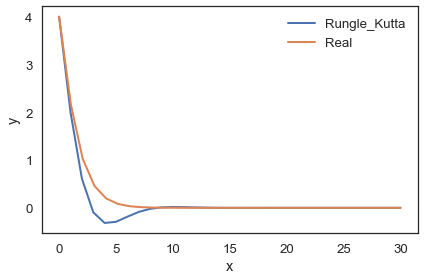

In [620]:
system = make_system(0,4,-2,1,0,30)

results = run2_rk4(system, fun_P, fun_Q)

plot(results.y, label='Rungle_Kutta')

x=linspace(0,30,30)
y=(4+2*x)*exp(-x)
plot(x,y, label='Real')

decorate(xlabel='x',ylabel='y')

通过上图对比，我们发现在$x=5$左右的误差较大

因此我们将步长缩小到$h=0.5$，再运行仿真：



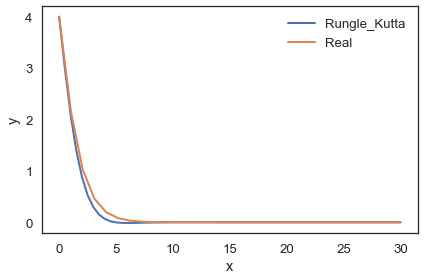

In [621]:
system = make_system(0,4,-2,0.5,0,30)

results = run2_rk4(system, fun_P, fun_Q)

plot(results.y, label='Rungle_Kutta')

x=linspace(0,30,30)
y=(4+2*x)*exp(-x)
plot(x,y, label='Real')

decorate(xlabel='x',ylabel='y')

由上图可知，精度提高了

## 炮弹发射问题
对于炮弹发射问题，在竖直方向上，利用run2_rk4()函数即可求解位移关系曲线

定义位移关系：
$$\frac{d^2s}{dt^2}=9.8$$

In [622]:
def fun1(x,y):
    f1 = 0
    return f1

In [623]:
def fun2(x,y):
    f2 = 9.8
    return f2

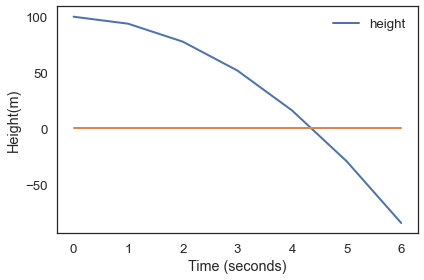

In [624]:
system = make_system(0,0,0,1,0,6)

results = run2_rk4(system, fun1, fun2)

plot(100-results.y, label='height')

x=[0,1,2,3,4,5,6]
y=[0,0,0,0,0,0,0]
plot(x,y)

decorate(xlabel='Time (seconds)',ylabel='Height(m)')